In [16]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake


import temp

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [17]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrss,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [18]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

pangeo-cmip6-ESM Collection with 235624 entries:
	> 15 activity_id(s)

	> 32 institution_id(s)

	> 69 source_id(s)

	> 101 experiment_id(s)

	> 135 member_id(s)

	> 29 table_id(s)

	> 313 variable_id(s)

	> 10 grid_label(s)

	> 235624 zstore(s)

	> 60 dcpp_init_year(s)

In [19]:
df['experiment_id'].unique()

array(['histSST', 'piClim-CH4', 'piClim-NTCF', 'piClim-control', 'ssp370',
       'piClim-2xDMS', 'piClim-2xdust', 'piClim-2xfire', 'piClim-2xss',
       'piClim-BC', 'piClim-HC', 'piClim-N2O', 'piClim-OC', 'piClim-SO2',
       'piClim-aer', '1pctCO2-bgc', 'esm-ssp585', 'hist-bgc',
       'amip-4xCO2', 'amip-future4K', 'amip-m4K', 'amip-p4K', 'amip',
       'abrupt-2xCO2', 'abrupt-solp4p', 'abrupt-0p5xCO2', 'amip-lwoff',
       'amip-p4K-lwoff', 'abrupt-solm4p', 'aqua-4xCO2',
       'aqua-control-lwoff', 'aqua-control', 'aqua-p4K-lwoff', 'aqua-p4K',
       'historical', 'piControl', '1pctCO2', 'abrupt-4xCO2', 'esm-hist',
       'esm-piControl', 'ssp126', 'ssp245', 'ssp585',
       'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG', 'hist-aer',
       'hist-nat', 'hist-CO2', 'hist-sol', 'hist-stratO3', 'hist-volc',
       'ssp245-GHG', 'ssp245-aer', 'ssp245-nat', 'ssp245-stratO3',
       'dcppA-hindcast', 'dcppA-assim', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 

In [20]:
cat = col.search(experiment_id=['ssp245','historical'],  # pick the `historical` forcing experiment
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='pr',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)


In [21]:
time_slice = slice('1850','2100') # specific

In [22]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
gmst_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gmst = (
        (ds['pr'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )
    
    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 48 group(s)


In [23]:
ssp_dict = {}
for name, ds in ds_dict.items():
    if 'ssp' not in name: continue
        
    add_hist_ds = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_ds in ds_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_ds = hist_ds
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_ds is not None:
        ds_ssp = xr.concat([add_hist_ds, ds],dim='time')
        ssp_dict[name] = ds_ssp

In [26]:
ssp_ds = ssp_dict[list(ssp_dict.keys())[0]]
temperature_change = (
    ssp_ds['pr'].sel(time=slice('2080','2100')).mean(dim='time') -
    ssp_ds['pr'].sel(time=slice('1980','2000')).mean(dim='time')
).compute() 
temperature_change.attrs.update(ssp_ds.attrs)
temperature_change = temperature_change.rename(
    r'precipiation change (meters) from 1980-2000 to 2080-2100'
)

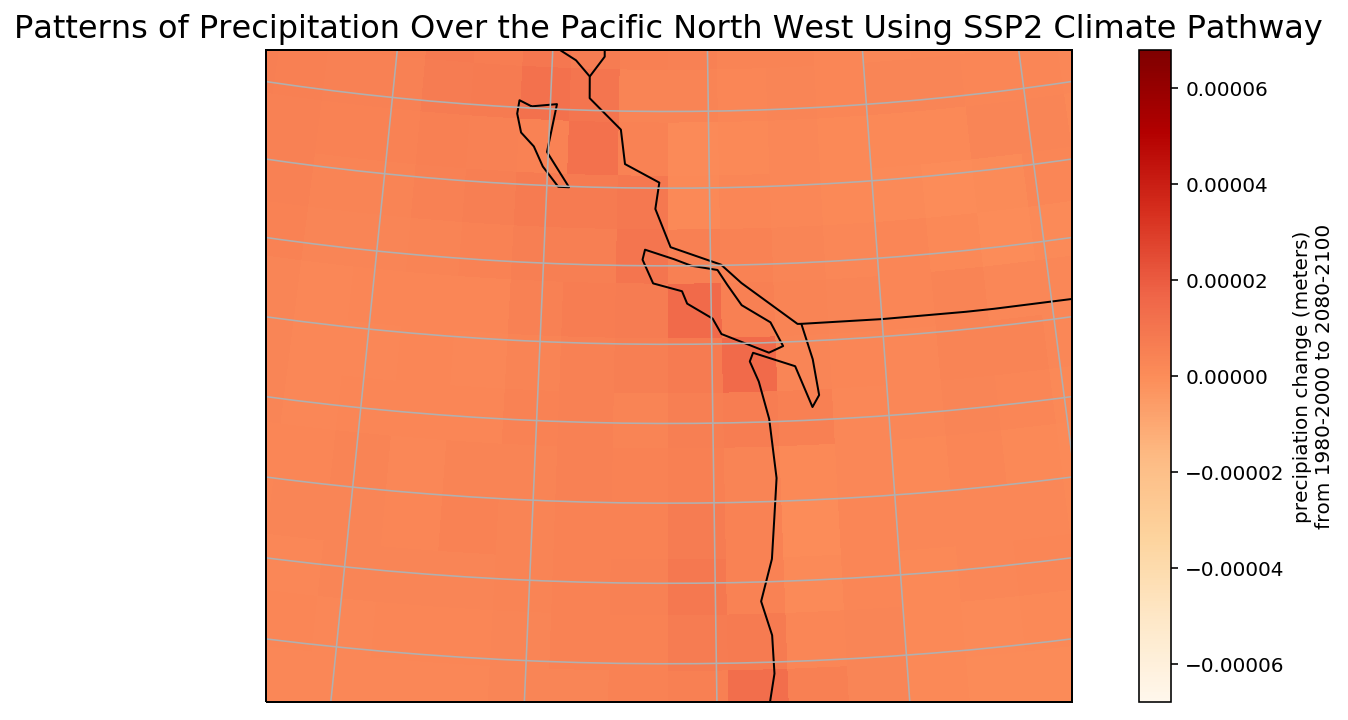

In [27]:
import cartopy.crs as ccrs
import numpy as np

ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame


central_lat=49.2827
central_long=-123.1207
extent=[-140,-115,40,55]
central_lon=np.mean(extent[:2])
central_lat=np.mean(extent[2:])

plt.figure(figsize=(12,6))
ax=plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.stock_img()

q = temperature_change.plot(ax=ax, transform = geo, cmap="OrRd") # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.gridlines()


ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of Precipitation Over the Pacific North West Using SSP2 Climate Pathway',fontsize=16, ha='center');

